# Anomaly Detection using isolation forrest and scikit-learn

First, lets create our Sagemaker session and role, and create a S3 prefix to use for the notebook example.

In [29]:
import boto3
import botocore
import sagemaker
import sys
from os import path

# S3 prefix
bucket = 'sagemaker-vadimd-default'
prefix = 'anomaly-detection'

import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://sagemaker-vadimd-default/anomaly-detection


# Obtain and Inspect Example Data

Our data comes from the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset [1]. These data consists of the number of New York City taxi passengers over the course of six months aggregated into 30-minute buckets. We know, a priori, that there are anomalous events occurring during the NYC marathon, Thanksgiving, Christmas, New Year's day, and on the day of a snow storm.

[1] https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv

In [14]:
%%time

import pandas as pd
import urllib.request

data_filename = 'nyc_taxi.csv'
data_source = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'

urllib.request.urlretrieve(data_source, data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=',')

CPU times: user 26.9 ms, sys: 115 µs, total: 27 ms
Wall time: 347 ms



Before training any models it is important to inspect our data, first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

In [15]:
taxi_data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


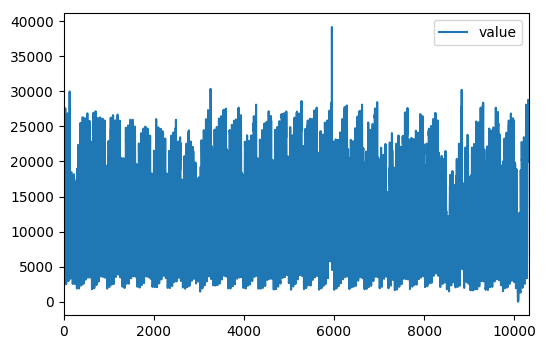

In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

taxi_data.plot()

Human beings are also extraordinarily good at perceiving patterns. Note, for example, that something uncharacteristic occurs at around datapoint number 6000. Additionally, as we might expect with taxi ridership, the passenger count appears more or less periodic. Let's zoom in to not only examine this anomaly but also to get a better picture of what the "normal" data looks like.

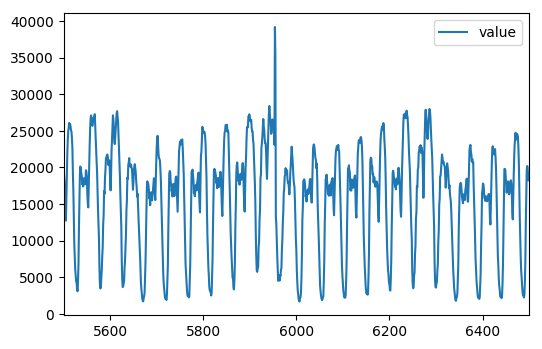

In [17]:
taxi_data[5500:6500].plot()



Here we see that the number of taxi trips taken is mostly periodic with one mode of length approximately 50 data points. In fact, the mode is length 48 since each datapoint represents a 30-minute bin of ridership count. Therefore, we expect another mode of length $336 = 48 \times 7$, the length of a week. Smaller frequencies over the course of the day occur, as well.

For example, here is the data across the day containing the above anomaly:



In [ ]:
taxi_data[5952:6000]


Once we have the data locally, we can use use the tools provided by the SageMaker Python SDK to upload the data to a default bucket.

In [34]:
s3_path = path.join(prefix, data_filename)

train_input = boto3.Session().resource('s3').Bucket(bucket).Object(
    s3_path).upload_file(data_filename)

print(s3_path)

anomaly-detection/nyc_taxi.csv


## Create a Scikit-learn script to train with <a class="anchor" id="create_sklearn_script"></a>
SageMaker can now run a scikit-learn script using the `SKLearn` estimator. When executed on SageMaker a number of helpful environment variables are available to access properties of the training environment, such as:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to. Any artifacts saved in this folder are uploaded to S3 for model hosting after the training job completes.
* `SM_OUTPUT_DIR`: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing two input channels, 'train' and 'test', were used in the call to the `SKLearn` estimator's `fit()` method, the following environment variables will be set, following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAIN`: A string representing the path to the directory containing data in the 'train' channel
* `SM_CHANNEL_TEST`: Same as above, but for the 'test' channel.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance. For example, the script that we will run in this notebook is the below:

In [36]:
!pygmentize training_script.py

import argparse
import pandas as pd
import os

from sklearn import tree
from sklearn.externals import joblib
from sklearn.ensemble import IsolationForest


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here. In this simple example we are just including one hyperparameter.
    parser.add_argument('--n_estimators', type=int, default=100)
    parser.add_argument('--max_features', type=float, default=1.0)

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])    

    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    input_file = os.path.join(args.train, "nyc_taxi.csv")
    train_data 

Because the Scikit-learn container imports your training script, you should always put your training code in a main guard `(if __name__=='__main__':)` so that the container does not inadvertently run your training code at the wrong point in execution.

For more information about training environment variables, please visit https://github.com/aws/sagemaker-containers.

## Create SageMaker Scikit Estimator <a class="anchor" id="create_sklearn_estimator"></a>

To run our Scikit-learn training script on SageMaker, we construct a `sagemaker.sklearn.estimator.sklearn` estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.
* __hyperparameters__ *(optional)*: A dictionary passed to the train function as hyperparameters.

To see the code for the SKLearn Estimator, see here: https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/sklearn

In [10]:
from sagemaker.sklearn.estimator import SKLearn

script_path = 'training_script.py'

sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={})

## Train SKLearn Estimator on Iris data <a class="anchor" id="train_sklearn"></a>
Training is very simple, just call `fit` on the Estimator! This will start a SageMaker Training job that will download the data for us, invoke our scikit-learn code (in the provided script file), and save any model artifacts that the script creates.

In [ ]:
sklearn.fit({'train': f"s3://{bucket}/{s3_path}"})

## Using the trained model to make inference requests <a class="anchor" id="inference"></a>

### Deploy the model <a class="anchor" id="deploy"></a>

Deploying the model to SageMaker hosting just requires a `deploy` call on the fitted model. This call takes an instance count and instance type.

In [37]:
predictor = sklearn.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------------!

### Choose some data and use it for a prediction <a class="anchor" id="prediction_request"></a>

In order to do some predictions, we'll extract some of the data we used for training and do predictions against it. This is, of course, bad statistical practice, but a good way to see how the mechanism works.

In [42]:
sample_input = [[0], # very low value, expect it to be identified as outlier
                [8127],  # average value, extect it to be identifies as non-outlier
                [10e5]]  # very high value, expect to be identified as outlier

Prediction is as easy as calling predict with the predictor we got back from deploy and the data we want to do predictions with. The output from the endpoint return an numerical representation of the classification prediction; in the original dataset, these are flower names, but in this example the labels are numerical. We can compare against the original label that we parsed.

In [ ]:
print(predictor.predict(sample_input)) # here, ""-1" means outlier and "1" means non-outlier value

### Endpoint cleanup <a class="anchor" id="endpoint_cleanup"></a>

When you're done with the endpoint, you'll want to clean it up.

In [ ]:
sklearn.delete_endpoint()